In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

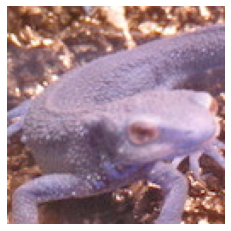

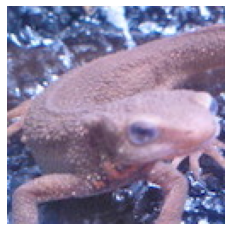

(128, 128, 3)


In [2]:
# 1
# cv2.imread() 的系数是按 BGR顺序排列的
# 读取图片，第二个参数0是灰色，1是彩色
# opencv是BGR通道，plt默认RGB通道
img = cv2.imread("imori.jpg")
plt.axis('off')
plt.imshow(img)
cv2.imshow("1", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.show()

red = img[:, :, 2].copy()
blue = img[:, :, 0].copy()
img[:, :, 0] = red
img[:, :, 2] = blue

plt.axis('off')
plt.imshow(img)
plt.show()
print(img.shape)

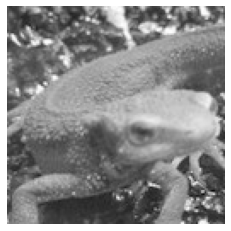

In [97]:
# 2 灰度化
img = cv2.imread("imori.jpg")
blue = np.array(img[:, :, 0].copy(), dtype='float64')
blue *= 0.0722

green = np.array(img[:, :, 1].copy(), dtype='float64')
green *= 0.7152

red = np.array(img[:, :, 2].copy(), dtype='float64')
red *= 0.2126

img[:, :, 0] = red+green+blue
img[:, :, 1] = red+green+blue
img[:, :, 2] = red+green+blue


# plt.imshow函数不会帮助你正确的构成128*128*3的图像
# cv2.imshow可以根据128*128生成3个通道
plt.axis('off')
plt.imshow(img)
plt.show()

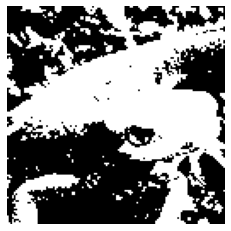

(128, 128, 3)

In [99]:
# 3 二值化
# 二值化是将图像使用黑和白两种颜色表示的方法。
th = 128
img[img < th] = 0
img[img >= th] = 255

plt.axis('off')
plt.imshow(img)
plt.show()
img.shape

float32
threshold >> 127


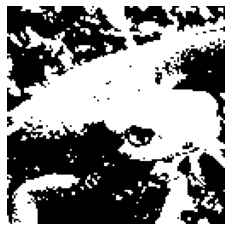

In [104]:
#  4大津二值化算法
# Gray scale
def BGR2GRAY(img):
    b = img[:, :, 0].copy()
    g = img[:, :, 1].copy()
    r = img[:, :, 2].copy()
    
    img[:, :, 0] = 0.2126 * r + 0.7152 * g + 0.0722 * b
    img[:, :, 1] =  0.2126 * r + 0.7152 * g + 0.0722 * b
    img[:, :, 2] =  0.2126 * r + 0.7152 * g + 0.0722 * b
    # Gray scale
    out = img
    out = out.astype(np.uint8)
    return out

def otsu_binarization(img, th=128):
    max_s = 0
    max_t = 0
    for i in range(1, 256):
        ts = img[np.where(img<i)]
        m0 = ts.mean() if len(ts) > 0 else 0
        w0 = len(ts) / H * W
        tb = img[np.where(img >= i)]
        m1 = tb.mean() if len(tb) > 0 else 0
        w1 = len(tb) / H * W
        if max_s < w0 * w1 * ((m0 - m1)**2):
            max_s = w0 * w1 * ((m0 - m1)**2)
            max_t = i
    print("threshold >>", max_t)
    th = max_t
    img[img < th] = 0
    img[img >= th] = 255
    return img
    
img4 = cv2.imread("imori.jpg").astype(np.float32)
print(img4.dtype)
# 高度、宽度、通道
H, W, C =img4.shape
out = BGR2GRAY(img4)
out = otsu_binarization(out)

# cv2.imshow("result", out)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.axis('off')
plt.imshow(out)

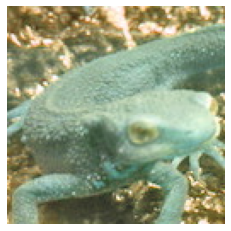

In [94]:
# 5 HSV变换

def BGR2HSV(_img):
    img = _img.copy() / 255
    # 构建HSV矩阵
    hsv = np.zeros_like(img, dtype=np.float32)
    # 128*128中三个通道的最大值和最小值，以及最小值的索引
    Max = np.max(img, axis=2).copy()
    Min = np.min(img, axis=2).copy()
    min_arg = np.argmin(img, axis=2)
 
    # H
    hsv[..., 0][np.where(Max == Min)] = 0
    # if min == B
    ind = np.where(min_arg == 0)
    hsv[..., 0][ind] = 60 * (img[..., 1][ind] - img[..., 2][ind]) / (Max[ind] - Min[ind]) + 60
    # if min == R
    ind = np.where(min_arg == 2)
    hsv[..., 0][ind] = 60 * (img[..., 0][ind] - img[..., 1][ind]) / (Max[ind] -Min[ind]) + 180
    ## if min == G
    ind = np.where(min_arg == 1)
    hsv[..., 0][ind] = 60 * (img[..., 2][ind] - img[..., 0][ind]) / (Max[ind] - Min[ind]) + 300

    # S
    hsv[..., 1] = Max.copy() - Min.copy()
    
    # V
    hsv[..., 2] = Max.copy()
    
    return hsv

def HSV2BRG(_img, hsv):
    img = _img.copy() / 255.
    Max =  np.max(img, axis=2).copy()
    Min = np.min(img, axis=2).copy()
    
    img = np.zeros_like(_img)
    H = hsv[..., 0]
    S = hsv[..., 1]
    V = hsv[..., 2]
    
    c = S
    _h = H / 60.
    x = c * (1 - np.abs(_h % 2 - 1))
    z = np.zeros_like(H)
    
    # 注意，cv2是BGR排列的
#     vals = [[z, x, c], [z, c, x],[x, c, z],[c, x, z], [c, z, x], [x, z, c]]
    # plt是按RGB排列的
    vals = [[c, x, z], [x, c, z], [z, c, x],[z, x, c], [x, z, c], [c, z, x]]
    for i in range(6):
        # 掩层
        ind = np.where((i <= _h) & (_h < (i+1)))
        img[..., 0][ind] = (V - c)[ind] + vals[i][0][ind]
        img[..., 1][ind] = (V - c)[ind] + vals[i][1][ind]
        img[..., 2][ind] = (V - c)[ind] + vals[i][2][ind]
    
    img[np.where(Max == Min)] = 0
    # 保证像素点在0到1之间
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

img = cv2.imread("imori.jpg").astype(np.float32)

hsv = BGR2HSV(img)
hsv[..., 0] = (hsv[..., 0] + 180) % 360
img = HSV2BRG(img, hsv)

tmp = out.copy()
out[..., 0] = tmp[..., 2]
out[..., 2] = tmp[..., 0]
plt.axis('off')
plt.imshow(img)

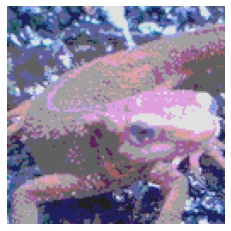

In [7]:
# 6 减色处理
img = cv2.imread("imori.jpg")
ind32 = np.where((img >= 0) & (img < 64))
ind96 = np.where((img >=64) & (img < 128))
ind160 = np.where((img >= 128) & (img < 192))
ind224 = np.where((img >= 192) & (img < 256))
img[ind32] = 32
img[ind96] = 96
img[ind160] = 160
img[ind224] = 224

b = img[:, :, 0].copy()
r = img[:, :, 2].copy()
img[:, :, 0] = r
img[:, :, 2] = b
plt.axis('off')
plt.imshow(img)

In [8]:
# np.where得到的tuple对应维度
# 例如：7是(0, 2)，是在第一个元组和第二个元组各取第一个组成他的坐标
x = np.arange(10).reshape(2, 5)
x[0][2] = 7
np.where(x > 5), x

((array([0, 1, 1, 1, 1], dtype=int64), array([2, 1, 2, 3, 4], dtype=int64)),
 array([[0, 1, 7, 3, 4],
        [5, 6, 7, 8, 9]]))

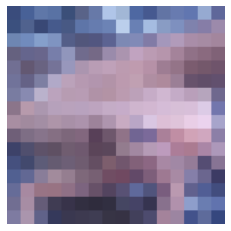

In [9]:
# 7 平均池化
img = cv2.imread("imori.jpg")
h, w, c = img.shape
nh = int(h / 8)
nw = int(w / 8)
# 是每个通道单独做平均池化
for i in range(nh):
    y_b = i * 8
    for j in range(nw):
        x_b = j * 8
        for k in range(c):
                img[x_b : x_b+8, y_b: y_b+8, k] = 1 / 64 * img[x_b : x_b+8, y_b: y_b+8, k].sum()
  
b = img[:, :, 0].copy()
r = img[:, :, 2].copy()
img[:, :, 0] = r
img[:, :, 2] = b
plt.axis('off')
plt.imshow(img)

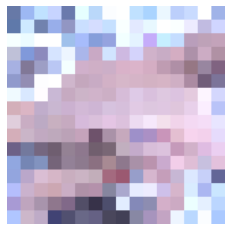

In [10]:
# 8 最大池化
img = cv2.imread("imori.jpg")
h, w, c = img.shape
nh = int(h / 8)
nw = int(w / 8)
# 是每个通道单独做平均池化
for i in range(nh):
    y_b = i * 8
    for j in range(nw):
        x_b = j * 8
        for k in range(c):
                img[x_b : x_b+8, y_b: y_b+8, k] = img[x_b : x_b+8, y_b: y_b+8, k].max()
                
b = img[:, :, 0].copy()
r = img[:, :, 2].copy()
img[:, :, 0] = r
img[:, :, 2] = b
plt.axis('off')
plt.imshow(img)

<ipython-input-86-12d225ca7ba8>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out = np.zeros((h+pad*2, w+pad*2, c), dtype=np.float)
<ipython-input-86-12d225ca7ba8>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out[pad: pad+h, pad:pad+w] = img.copy().astype(np.float)
<ipython-input-86-12d225ca7ba8>:13: DeprecationWarning: `np.float

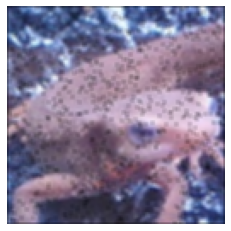

In [86]:
import cv2
import numpy as np


def guass(img, k_size, sigma):
    h, w, c = img.shape
    
    # 填充
    pad = k_size // 2
    out = np.zeros((h+pad*2, w+pad*2, c), dtype=np.float)
    out[pad: pad+h, pad:pad+w] = img.copy().astype(np.float)
    
    k = np.zeros((k_size, k_size), dtype=np.float)
    # 因为是对称分布的，需要对应位置的计算相同，用到了pad(对奇数)
    for y in range( -pad, -pad + k_size):
        for x in range(-pad, -pad+k_size):
            k[x+pad, y+pad] = np.exp( -(x ** 2 + y ** 2) / (2 * (sigma ** 2)))
    k /= (2 * np.pi * sigma * sigma)
    k /= k.sum()
    
    tmp = out.copy()
    
    for y in range(h):
        for x in range(w):
            for c in range(3):
                out[pad + y, pad + x, c] = np.sum(k* tmp[y: y + k_size, x: x + k_size, c])
                
    out = np.clip(out, 0, 255)
    out = out[pad:pad+h, pad:pad+w].astype(np.uint8)
    return out

# Read image
img = cv2.imread("imori_noise.jpg")

out = guass(img, 3, 1.3)

tmp = out.copy()
out[..., 0] = tmp[..., 2]
out[..., 2] = tmp[..., 0]
plt.axis('off')
plt.imshow(out)

<ipython-input-93-7874dba7fbc0>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out = np.zeros((H + pad * 2,  W + pad * 2, C), dtype=np.float)
<ipython-input-93-7874dba7fbc0>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out[pad: pad+H, pad:pad+W] = img.copy().astype(np.float)


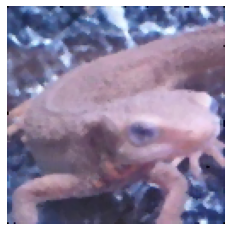

In [93]:
# 10 中值滤波

def mid(img, k_size):
    H, W, C = img.shape
    
    # 填充
    pad = k_size // 2
    out = np.zeros((H + pad * 2,  W + pad * 2, C), dtype=np.float)
    out[pad: pad+H, pad:pad+W] = img.copy().astype(np.float)
    
    tmp = out.copy()
    
    for y in range(H):
        for x in range(W):
            for c in range(C):
                out[pad+y, pad+x, c] = np.median(tmp[y: y+k_size, x: x+k_size, c])
    out = np.clip(out, 0, 255)
    out = out[pad:pad+H, pad:pad+W].astype(np.uint8)
    return out
img = cv2.imread("imori_noise.jpg")

out = mid(img, 3)

tmp = out.copy()
out[..., 0] = tmp[..., 2]
out[..., 2] = tmp[..., 0]
plt.axis('off')
plt.imshow(out)